# 用户行为模拟


* ## 模型设置

> 用户建模  
* 用户信息base  
* 行为behaviorbase, 定义每种行为，用户付出的行为量化值（聊天轮数，时长，登陆次数，评论次数等）和获取的奖励
* action




In [3]:
import numpy as np
from scipy.stats import halfgennorm,gennorm

In [84]:
class behaviorBase:
    def __init__():
        return
    def generate_qty(self):
        # to be implemented
        return
    
    def generate_reward(self):
        # to be implemented
        return
    
    #行为量化值 如观看时间，登陆
    def getQty(self): 
        self.behavior_qty=self.generate_qty()
        return self.behavior_qty 

    def getReward(self):
        self.reward=self.generate_reward()
        return self.reward

#观看行为
class view(behaviorBase):
    def __init__(self,*rnd,size,exchange):
        self.size = size #日活数量
        self.rnd = rnd #模拟的指数分布参数
        self.exchange = exchange # 行为qty对应的奖励换算比例
        
    def generate_qty(self):
        r = np.random.exponential(*self.rnd,self.size)
        self.qty = np.array(list(map(int,r))) #转化成int型
        return self.qty 
    
    def generate_reward(self):
        return self.qty *self.exchange

#首启-新用户
class firsttime_start(behaviorBase):
    def __init__(self,size,ratio,exchange):
        self.size = size*ratio #size*新用户比例
        self.exchange = exchange # 行为qty对应的奖励换算比例
        
    def generate_qty(self):
        self.qty = self.size #数量=每日新用户
        return self.qty 
    
    def generate_reward(self):
        return self.qty *self.exchange
    
#首次关注
class firstsub_start(behaviorBase):
    def __init__(self,size,ratio,exchange):
        self.size = size*ratio #size*首次关注的比例
        self.exchange = exchange # 行为qty对应的奖励换算比例
        
    def generate_qty(self):
        self.qty = self.size #数量=每日新用户
        return self.qty 
    
    def generate_reward(self):
        return self.qty *self.exchange
    
    
#评论
class comment(behaviorBase):
    def __init__(self,*rnd,size,exchange):
        self.rnd= rnd
        self.size =  size   
        self.exchange = exchange # 行为qty对应的奖励换算比例
        
    def generate_qty(self):
        r = np.random.exponential(*self.rnd,self.size) #评论呈现出指数分布，最多的是0
        self.qty = np.array(list(map(int,r))) #转化成int型
        return self.qty 
    
    def generate_reward(self):
        return self.qty *self.exchange

In [5]:
class actionBase:
    def __init__(self):
        return
    
    def call_act(self):
        #do actions
        return

In [6]:
class userBase(actionBase):
    def __init__(self,new_ratio):
        self.new_ratio = new_ratio
        
    def call_act():
        pass

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [189]:
DAU = int(1e5)
r = 10

<Axes: ylabel='Count'>

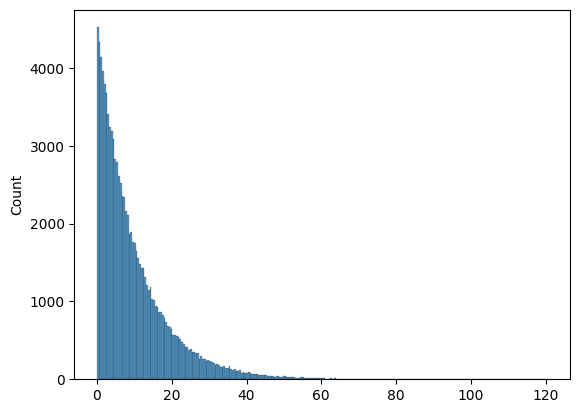

In [193]:
t_rounds = np.random.exponential((r),(DAU))
# sns.distplot(list(map(int,t)))
sns.histplot(t_rounds)

In [194]:
pd.Series(t_rounds).describe()

count    100000.000000
mean          9.997552
std           9.981791
min           0.000044
25%           2.897775
50%           6.941277
75%          13.825704
max         120.601886
dtype: float64

In [105]:
def calc_rate(input_tokens,output_tokens,model='sonnet'):
    if model == 'sonnet':
        in_token_rate = 3/1e6
        out_token_rate = 15/1e6
    elif model == 'haiku':
        in_token_rate = 0.25/1e6
        out_token_rate = 1.25/1e6
    elif model == 'opus':
        in_token_rate = 15/1e6
        out_token_rate = 75/1e6
    return in_token_rate*input_tokens+out_token_rate*output_tokens

<Axes: ylabel='Count'>

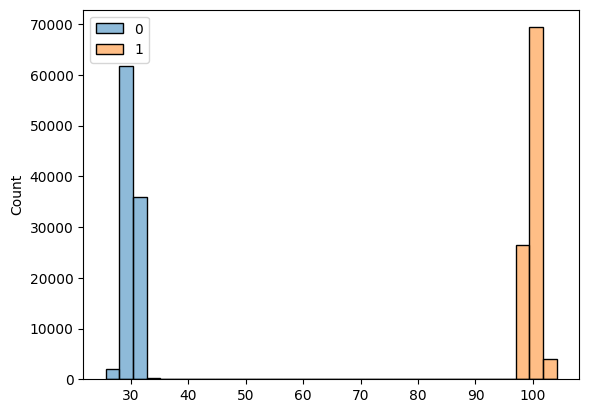

In [195]:
avg_input_round = 30
avg_output_round = 100
normal_dist = np.random.normal(loc=(avg_input_round,avg_output_round), scale=1, size=(DAU,2))
sns.histplot(normal_dist)

In [196]:
avg_cost_round = calc_rate(normal_dist.T[0],normal_dist.T[1])
avg_cost_round.shape

(100000,)

In [197]:
rounds_cost = t_rounds * avg_cost_round

总rounds:999755,总cost:1589


<Axes: ylabel='Count'>

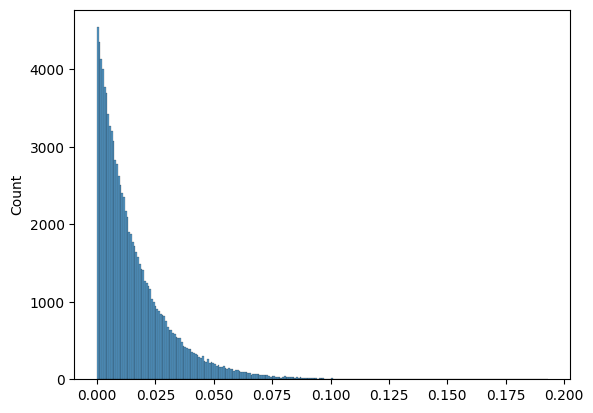

In [200]:
print('总rounds:%d,总cost:%d' %(t_rounds.sum(),rounds_cost.sum()))
sns.histplot(rounds_cost)

In [201]:
rounds_df = pd.Series(t_rounds)
rounds_df.describe()

count    100000.000000
mean          9.997552
std           9.981791
min           0.000044
25%           2.897775
50%           6.941277
75%          13.825704
max         120.601886
dtype: float64

In [202]:
rounds_cost = pd.Series(rounds_cost)
rounds_cost.describe()

count    1.000000e+05
mean     1.589538e-02
std      1.587272e-02
min      6.892836e-08
25%      4.604520e-03
50%      1.103697e-02
75%      2.198275e-02
max      1.930125e-01
dtype: float64

In [203]:
cost_pct = []
total = rounds_cost.sum()
for q in np.arange(0,1,0.05):
    b = rounds_cost.quantile(q)
    cost_pct.append([1-q,rounds_cost[rounds_cost>=b].sum()/total])
    

In [204]:
data = pd.DataFrame(cost_pct,columns=['x','y'])

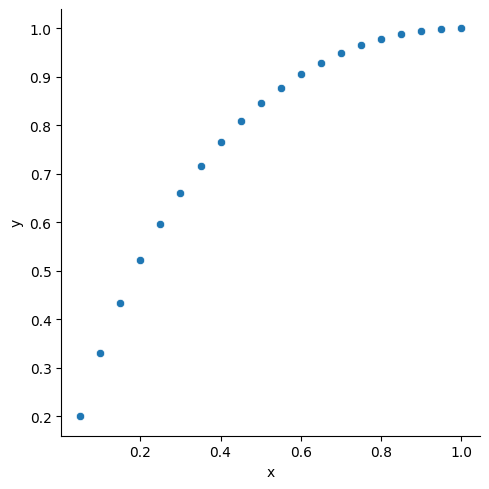

In [205]:
sns.relplot(data=data,x='x',y='y')

In [355]:
from scipy import optimize

In [363]:
c=np.array([2,3,-5])
A_ub=np.array([[-2,5,-1],[1,3,1]])
B_ub=np.array([-10,12])
A_eq=np.array([[1,1,1]])
B_eq=np.array([7])
x1=(0,100)
x2=(0,100)
x3=(0,7)
res=optimize.linprog(-c,A_ub,B_ub,A_eq,B_eq,bounds=(x1,x2,x3))
print(res)

     con: array([0.])
     fun: -14.571428571428571
 message: 'Optimization terminated successfully.'
     nit: 8
   slack: array([0.        , 3.85714286])
  status: 0
 success: True
       x: array([6.42857143, 0.57142857, 0.        ])


In [413]:
x = np.linspace(0,100,100)

In [414]:
y = np.log(3+2*x)
y = np.exp(-10*x)

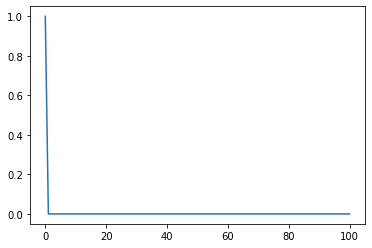

In [415]:
plt.plot(x,y)

In [416]:
np.random.exponential(10,10)

array([ 2.04571528, 32.22290026, 11.01366368, 10.82994786,  2.77600893,
        3.761561  , 22.96969816,  3.34054414,  0.83794107, 25.95941906])